In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re

In [ ]:
!pip install tiktoken --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.7 MB/s eta 0:00:00


In [ ]:
import tiktoken

In [ ]:
data = pd.read_csv("../data/telegram_ads_v2.csv")
data.head(10)

,Text,Id
0,деревянная статуэтка 4000 рублей\nигра 400 руб...,"{'platform': 'telegram', 'wall_id': 1525972822..."
1,автокресло britax romer от 6 месяцев до 9 лет ...,"{'platform': 'telegram', 'wall_id': 1525972822..."
2,перчатки christian dior кожаные 8500\n(на одно...,"{'platform': 'telegram', 'wall_id': 1525972822..."
3,"сервиз чайная роза гдр -5500, \nкофейный серви...","{'platform': 'telegram', 'wall_id': 1525972822..."
4,сумка moschino винтаж -20.000 \n\nзабирать на ...,"{'platform': 'telegram', 'wall_id': 1525972822..."
5,"продам телевизор mystery, модель mtv-1922lw. ж...","{'platform': 'telegram', 'wall_id': 1525972822..."
6,шапка-шлем мужская finn flare.\nматериал: нату...,"{'platform': 'telegram', 'wall_id': 1525972822..."
7,парфюм мужской parfums genty.\nпроизводство: р...,"{'platform': 'telegram', 'wall_id': 1525972822..."
8,"1. «искусство древнего мира». дмитриева н.а., ...","{'platform': 'telegram', 'wall_id': 1525972822..."
9,"«лососи, бобры, каланы».\nкнига жака-ива кусто...","{'platform': 'telegram', 'wall_id': 1525972822..."


ChatGPT иногда съедает размер в формате 30*40 (выдаёт просто 3040), возможно, стоит заменить на  30x40  
Но это не точно

In [ ]:
def is_selling_text(text):
    for sub in (r'.*прода[еёю]тся.*', r'.*продажа.*', r'.*прода[юм].*'):
        if re.match(sub, text.lower()) is not None:
            return True
    return False

def is_bad_text(text):
    for sub in (r'.*куп(лю|им).*', r'.*сда(м|ю|дим|ется|ётся).*', r'.*аренд[ау].*', r'.*ищ(у|ем).*', r'.*продан(о|а|ы)?.*'):
        if re.match(sub, text.lower()) is not None:
            return True
    return False

def reformat_prices(text):
    # 35 к --> 35к, так ChatGPT лучше понимает
    # k, к, т - тысячи, р - рубли, л - лари / лиры, е - евро
    return re.sub(r'([0-9]+) ([kKкКтТрРлЛеЕeE]([^a-zA-Zа-яА-ЯёЁ0-9]|$))', r'\1\2', text)

def count_words(string):
    string = f" {string} "
    string = re.sub(r'([0-9])[.,-]([0-9])', r'\1\2', string)
    string = re.sub(r'[,.!?:;%)(|\'"*«»-]', ' ', string)
    return len(list(string.strip().split()))

def count_numbers(string):
    string = f" {string} "
    string = re.sub(r'([0-9])[.,-]([0-9])', r'\1\2', string)
    string = re.sub(r'[,.!?:;%)(|\'"*«»-]', ' ', string)
    reg = re.compile('.*[0-9]+')
    return sum(reg.match(s) is not None for s in string.strip().split())

def count_input_tokens(text):
    encoding = tiktoken.encoding_for_model("gpt-4-turbo-2024-04-09")
    return len(encoding.encode(text))

In [ ]:
data = data[data["Text"].apply(lambda t: not is_bad_text(t))]
data.shape

(170076, 2)

In [ ]:
data["Length"] = data.loc[:, "Text"].apply(count_words)
print(np.quantile(data["Length"].values, q=np.linspace(0, 1, 11)))
data = data[data["Length"] >= 5]

[  1.   6.   8.  11.  14.  17.  21.  27.  37.  56. 644.]


In [ ]:
data["Nums"] = data.loc[:, "Text"].apply(count_numbers)
data["Tokens"] = data.loc[:, "Text"].apply(count_input_tokens)
data["NumsPerWord"] = data.loc[:, "Nums"] / data.loc[:, "Length"]
data["TokensPerWord"] = data.loc[:, "Tokens"] / data.loc[:, "Length"]

In [ ]:
data[data["NumsPerWord"] > 0.5].head()

,Text,Id,Length,Nums,Tokens,NumsPerWord,TokensPerWord
25,"набор полотенец из 3 шт размеры 30*50, 50*90, ...","{'platform': 'telegram', 'wall_id': 1525972822...",17,9,44,0.529412,2.588235
746,"высота 85см , ширина 40см - 450₽","{'platform': 'telegram', 'wall_id': 1525972822...",5,3,23,0.600000,4.600000
1024,новый чемодан 65 см 68л\n2 000,"{'platform': 'telegram', 'wall_id': 1525972822...",7,4,17,0.571429,2.428571
1029,"столик, б/у\n, 50*50, высота 52\n500₽","{'platform': 'telegram', 'wall_id': 1525972822...",7,4,25,0.571429,3.571429
1105,iphone 13 512gb\n99% аккумулятор \n 60000р,"{'platform': 'telegram', 'wall_id': 1525972822...",6,4,20,0.666667,3.333333


In [ ]:
data["Text"] = data["Text"].apply(reformat_prices)

In [ ]:
explicit = data[data["Text"].apply(is_selling_text)].copy()
candidates = data[data["Text"].apply(lambda t: not is_selling_text(t))].copy()

explicit.shape, candidates.shape

((59723, 7), (101619, 7))

In [ ]:
explicit.head()

,Text,Id,Length,Nums,Tokens,NumsPerWord,TokensPerWord
5,"продам телевизор mystery, модель mtv-1922lw. ж...","{'platform': 'telegram', 'wall_id': 1525972822...",32,5,90,0.156250,2.812500
15,"продам телевизор supra, модель: stv-lc2222wd, ...","{'platform': 'telegram', 'wall_id': 1525972822...",17,5,55,0.294118,3.235294
16,"продаю новогодний венок, 35 см, полностью ручн...","{'platform': 'telegram', 'wall_id': 1525972822...",23,2,63,0.086957,2.739130
35,"продаю две ёлочки, 30 см, полностью ручная раб...","{'platform': 'telegram', 'wall_id': 1525972822...",16,2,46,0.125000,2.875000
45,продается прилесной участок в коттеджном посел...,"{'platform': 'telegram', 'wall_id': 1525972822...",118,10,431,0.084746,3.652542


In [ ]:
candidates.head()

,Text,Id,Length,Nums,Tokens,NumsPerWord,TokensPerWord
0,деревянная статуэтка 4000 рублей\nигра 400 руб...,"{'platform': 'telegram', 'wall_id': 1525972822...",12,4,43,0.333333,3.583333
1,автокресло britax romer от 6 месяцев до 9 лет ...,"{'platform': 'telegram', 'wall_id': 1525972822...",28,5,97,0.178571,3.464286
2,перчатки christian dior кожаные 8500\n(на одно...,"{'platform': 'telegram', 'wall_id': 1525972822...",13,1,43,0.076923,3.307692
3,"сервиз чайная роза гдр -5500, \nкофейный серви...","{'platform': 'telegram', 'wall_id': 1525972822...",11,2,40,0.181818,3.636364
4,сумка moschino винтаж -20.000 \n\nзабирать на ...,"{'platform': 'telegram', 'wall_id': 1525972822...",7,1,24,0.142857,3.428571


Немного визуализации

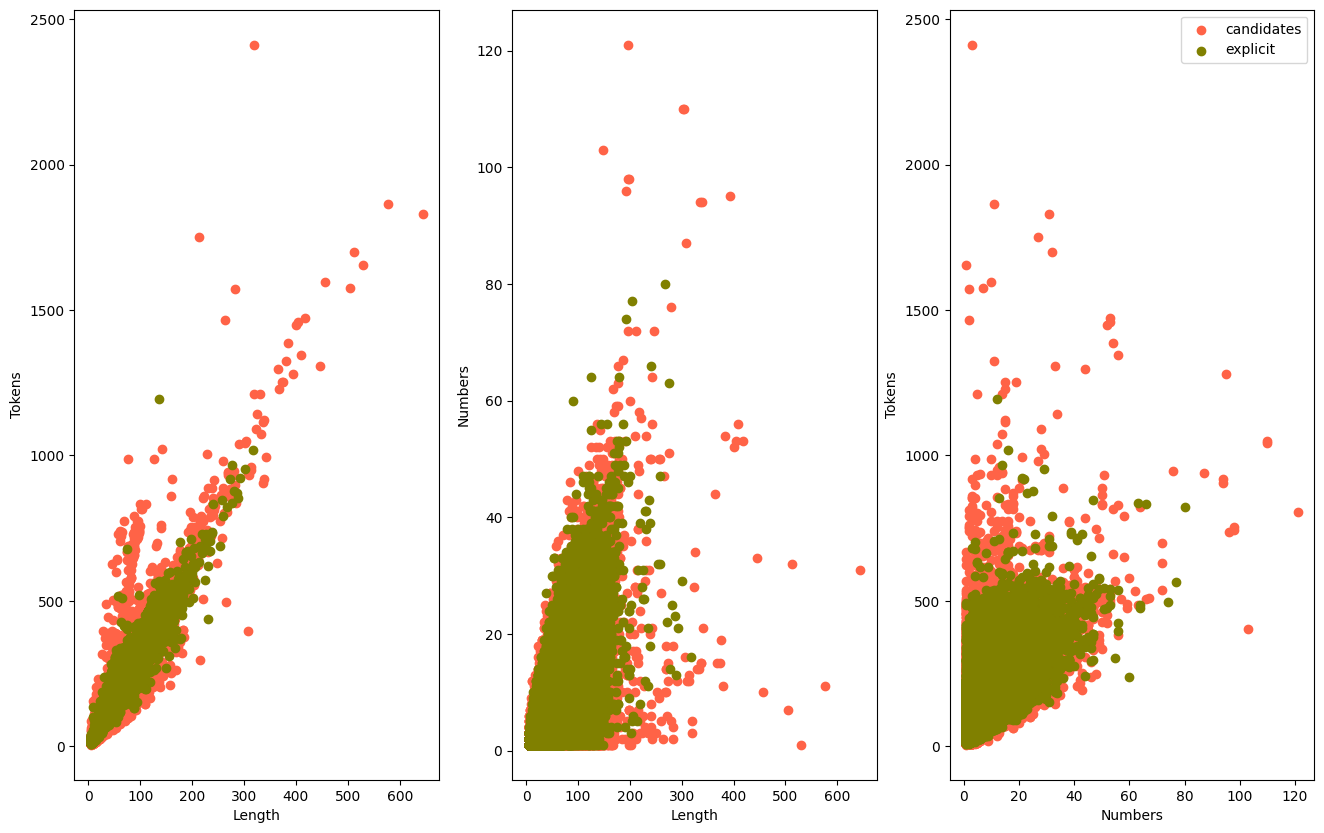

In [ ]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(16, 10))
ax0.scatter(candidates["Length"], candidates["Tokens"], color="tomato", label="candidates")
ax1.scatter(candidates["Length"], candidates["Nums"], color="tomato", label="candidates")
ax2.scatter(candidates["Nums"], candidates["Tokens"], color="tomato", label="candidates")

ax0.scatter(explicit["Length"], explicit["Tokens"], color="olive", label="explicit")
ax1.scatter(explicit["Length"], explicit["Nums"], color="olive", label="explicit")
ax2.scatter(explicit["Nums"], explicit["Tokens"], color="olive", label="explicit")

ax0.set_xlabel("Length")
ax0.set_ylabel("Tokens")
ax1.set_xlabel("Length")
ax1.set_ylabel("Numbers")
ax2.set_xlabel("Numbers")
ax2.set_ylabel("Tokens")

plt.legend()
plt.show()

Немного фильтрации

In [ ]:
for col in ("Length", "Nums", "Tokens", "NumsPerWord", "TokensPerWord"):
    print(col)
    print("\tExplicit:", explicit[col].values.min(), '->', *np.quantile(explicit[col].values, q=[0.01, 0.25, 0.5, 0.75, 0.99]).tolist(), '->', explicit[col].values.max())
    print("\tCandidates:", candidates[col].values.min(), '->', *np.quantile(candidates[col].values, q=[0.01, 0.25, 0.5, 0.75, 0.99]).tolist(), '->', candidates[col].values.max())

Length
	Explicit: 5 -> 5.0 13.0 23.0 39.0 135.0 -> 318
	Candidates: 5 -> 5.0 9.0 15.0 28.0 135.0 -> 644
Nums
	Explicit: 1 -> 1.0 2.0 3.0 5.0 25.0 -> 80
	Candidates: 1 -> 1.0 1.0 2.0 4.0 23.0 -> 121
Tokens
	Explicit: 9 -> 16.0 43.0 73.0 133.0 424.0 -> 1194
	Candidates: 5 -> 12.0 29.0 48.0 90.0 458.0 -> 2412
NumsPerWord
	Explicit: 0.006711409395973154 -> 0.028846153846153848 0.09271523178807947 0.14285714285714285 0.2 0.40625 -> 0.7692307692307693
	Candidates: 0.001890359168241966 -> 0.023255813953488372 0.09523809523809523 0.14814814814814814 0.21951219512195122 0.46153846153846156 -> 1.0
TokensPerWord
	Explicit: 1.4666666666666666 -> 2.25 2.9285714285714284 3.2 3.526315789473684 5.244897959183674 -> 14.88888888888889
	Candidates: 1.0 -> 1.7333333333333334 2.831209415584415 3.1538461538461537 3.5 4.75 -> 19.25


Видно, что за пределами 0.01 и 0.99 квантилей существуют какие-то, скорее всего, выбросы. Их смело можно выкинуть - много не потеряем

In [ ]:
mask_explicit, mask_candidates = np.array([True] * len(explicit)), np.array([True] * len(candidates))

for col in ["TokensPerWord"]:
    q1, q2 = np.quantile(explicit[col].values, q=[0.01, 0.99])
    mask_explicit = mask_explicit & ((explicit[col].values >= q1) & (explicit[col].values <= q2))

    q1, q2 = np.quantile(candidates[col].values, q=[0.01, 0.99])
    mask_candidates = mask_candidates & ((candidates[col].values >= q1) & (candidates[col].values <= q2))

for col in ["Nums", "Length", "Tokens", "NumsPerWord"]:
    q = np.quantile(explicit[col].values, q=0.99)
    mask_explicit = mask_explicit & (explicit[col].values <= q)

    q = np.quantile(candidates[col].values, q=0.99)
    mask_candidates = mask_candidates & (candidates[col].values <= q)

explicit = explicit.loc[mask_explicit, :]
candidates = candidates.loc[mask_candidates, :]

In [ ]:
for col in ("Length", "Nums", "Tokens", "NumsPerWord", "TokensPerWord"):
    print(col)
    print("\tExplicit:", explicit[col].values.min(), '->', *np.quantile(explicit[col].values, q=[0.01, 0.25, 0.5, 0.75, 0.99]).tolist(), '->', explicit[col].values.max())
    print("\tCandidates:", candidates[col].values.min(), '->', *np.quantile(candidates[col].values, q=[0.01, 0.25, 0.5, 0.75, 0.99]).tolist(), '->', candidates[col].values.max())

Length
	Explicit: 5 -> 5.0 13.0 23.0 38.0 109.0 -> 135
	Candidates: 5 -> 5.0 9.0 15.0 28.0 108.0 -> 135
Nums
	Explicit: 1 -> 1.0 2.0 3.0 5.0 19.0 -> 25
	Candidates: 1 -> 1.0 1.0 2.0 4.0 17.0 -> 23
Tokens
	Explicit: 12 -> 17.0 43.0 72.0 127.0 351.0 -> 424
	Candidates: 9 -> 12.0 29.0 48.0 87.0 360.0 -> 458
NumsPerWord
	Explicit: 0.007407407407407408 -> 0.028985507246376812 0.09090909090909091 0.1388888888888889 0.2 0.375 -> 0.40625
	Candidates: 0.007633587786259542 -> 0.024390243902439025 0.09523809523809523 0.14285714285714285 0.21428571428571427 0.4074074074074074 -> 0.46153846153846156
TokensPerWord
	Explicit: 2.25 -> 2.375 2.9375 3.2 3.52 5.056603773584905 -> 5.244897959183674
	Candidates: 1.7333333333333334 -> 2.0 2.8333333333333335 3.1538461538461537 3.5 4.448409570724843 -> 4.75


И ещё немного визуализации

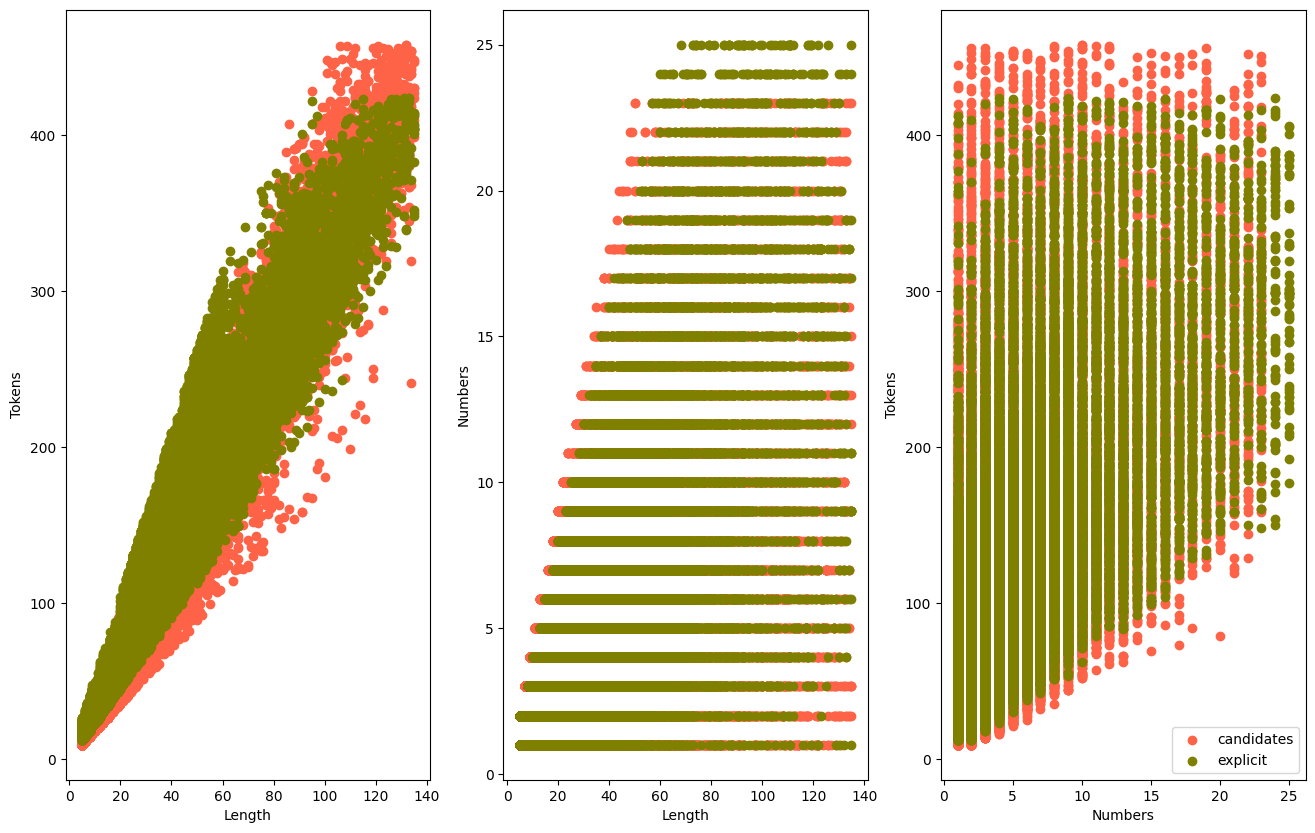

In [ ]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(16, 10))
ax0.scatter(candidates["Length"], candidates["Tokens"], color="tomato", label="candidates")
ax1.scatter(candidates["Length"], candidates["Nums"], color="tomato", label="candidates")
ax2.scatter(candidates["Nums"], candidates["Tokens"], color="tomato", label="candidates")

ax0.scatter(explicit["Length"], explicit["Tokens"], color="olive", label="explicit")
ax1.scatter(explicit["Length"], explicit["Nums"], color="olive", label="explicit")
ax2.scatter(explicit["Nums"], explicit["Tokens"], color="olive", label="explicit")

ax0.set_xlabel("Length")
ax0.set_ylabel("Tokens")
ax1.set_xlabel("Length")
ax1.set_ylabel("Numbers")
ax2.set_xlabel("Numbers")
ax2.set_ylabel("Tokens")

plt.legend()
plt.show()

In [ ]:
candidates[candidates["TokensPerWord"] == explicit["TokensPerWord"].values.min()].head()

,Text,Id,Length,Nums,Tokens,NumsPerWord,TokensPerWord
1738,"всё новое от застройщика, 5000 руб за все","{'platform': 'telegram', 'wall_id': 1525972822...",8,1,18,0.125,2.25
2952,"хна для бровей, цена за всё 2100 руб.","{'platform': 'telegram', 'wall_id': 1525972822...",8,1,18,0.125,2.25
6215,проспект славы \nразмер s\nnike dry academy 18,"{'platform': 'telegram', 'wall_id': 1779107701...",8,1,18,0.125,2.25
6254,nike dry academy 18\nразмер s\nпроспект славы,"{'platform': 'telegram', 'wall_id': 1779107701...",8,1,18,0.125,2.25
8260,2 новые тряпки на х-швабру. 200р,"{'platform': 'telegram', 'wall_id': 1779107701...",8,2,18,0.250,2.25


In [ ]:
explicit.shape, candidates.shape

((56975, 7), (96982, 7))

In [ ]:
filt = pd.concat([explicit, candidates])
filt = filt.sample(frac=1)
filt.shape

(153957, 7)

Баланс пабликов

In [ ]:
filt["Id"] = filt["Id"].apply(lambda x: re.sub('\'', '"', x))
filt.head()

,Text,Id,Length,Nums,Tokens,NumsPerWord,TokensPerWord
122157,продам:\n1) автомобильный усилитель jbl gto 75...,"{""platform"": ""telegram"", ""wall_id"": 1332882905...",120,24,352,0.200000,2.933333
154694,"скандинавский детектив, каждый за 7, или оба з...","{""platform"": ""telegram"", ""wall_id"": 1121942433...",11,2,32,0.181818,2.909091
86979,iuliiavy нарушил правила чата и не сможет писа...,"{""platform"": ""telegram"", ""wall_id"": 1332882905...",15,4,42,0.266667,2.800000
57351,продам коврик miniso sport для йоги \n20 лари ...,"{""platform"": ""telegram"", ""wall_id"": 1332882905...",12,1,43,0.083333,3.583333
145349,"бронь!!!! 500€, с аккаунтом и полным комплекто...","{""platform"": ""telegram"", ""wall_id"": 1121942433...",19,1,61,0.052632,3.210526


In [ ]:
import json

def get_wall_id(json_str):
    return json.loads(json_str)['wall_id']

In [ ]:
filt["Wall"] = filt["Id"].apply(get_wall_id)

In [ ]:
wall_vc = filt["Wall"].value_counts()
walls = dict(zip(wall_vc.index.values, wall_vc.values))
walls

{1332882905: 71241,
 1121942433: 39791,
 1466725454: 28611,
 1779107701: 9547,
 1525972822: 2620,
 1283242410: 2147}

In [ ]:
walls_dfs = {wall_id: filt[filt["Wall"] == wall_id].copy() for wall_id in walls}

In [ ]:
max_size = 28000
for wall_id in walls_dfs:
    prob = max_size / len(walls_dfs[wall_id])
    mask = np.random.choice([True, False], p=[min(1, prob), max(0, 1 - prob)], size=len(walls_dfs[wall_id]))
    walls_dfs[wall_id] = walls_dfs[wall_id].loc[mask, :]

filt = pd.concat(list(walls_dfs.values()))
filt.sample(frac=1)
filt.shape

(98233, 8)

In [ ]:
filt["Wall"].value_counts()

Wall
1466725454    27999
1332882905    27962
1121942433    27958
1779107701     9547
1525972822     2620
1283242410     2147
Name: count, dtype: int64

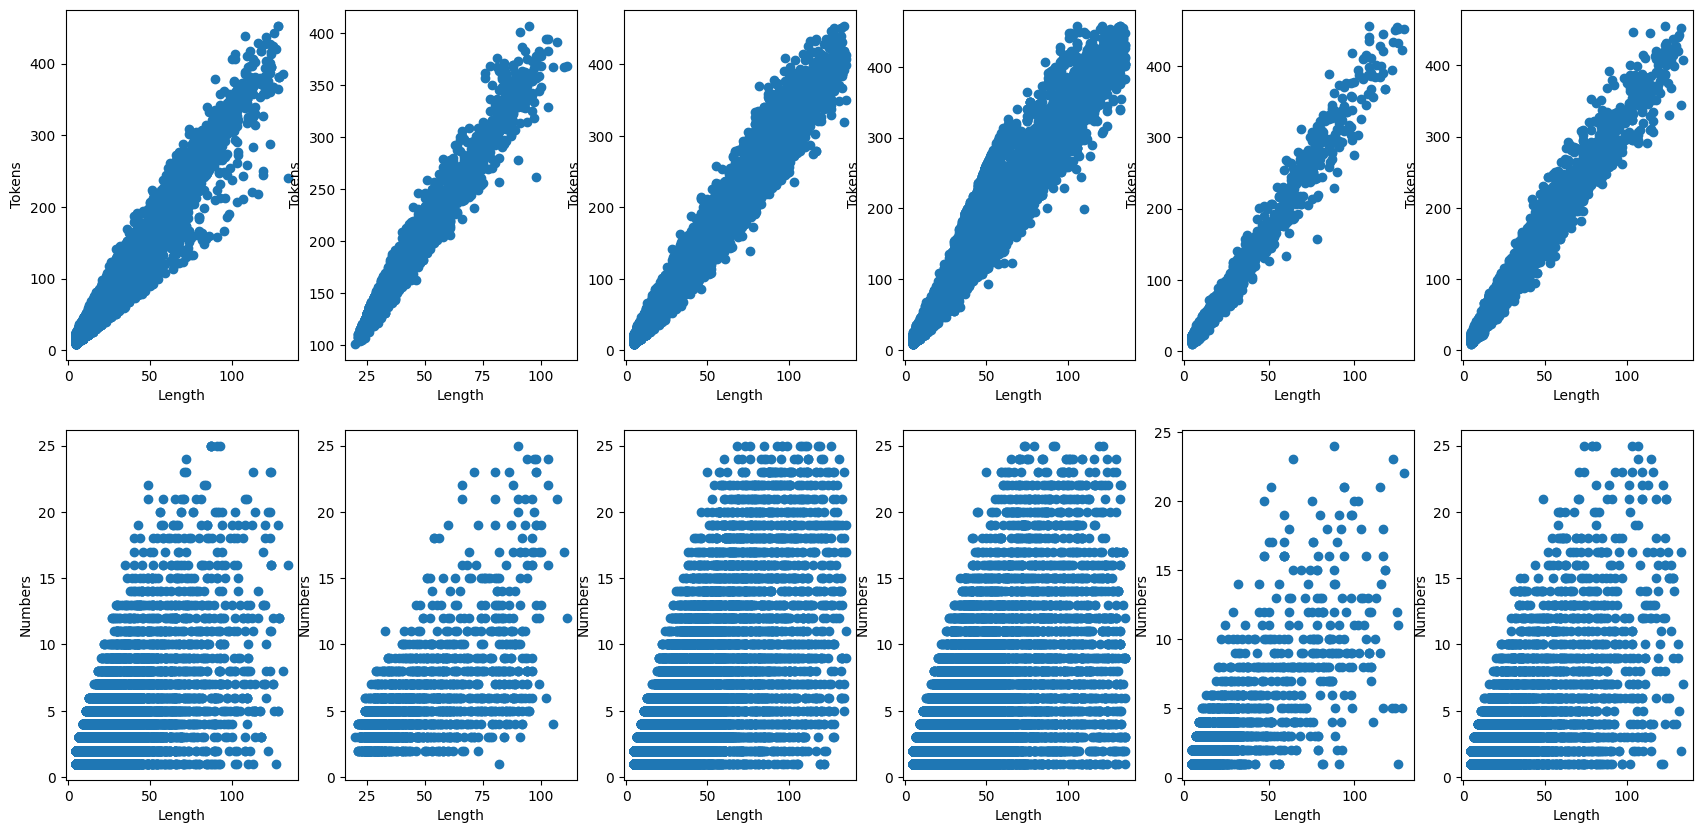

In [ ]:
fig, ax = plt.subplots(2, filt["Wall"].nunique(), figsize=(21, 10))
for idx, wall in enumerate(np.unique(filt["Wall"].values)):
    ax[0, idx].scatter(filt.loc[filt["Wall"] == wall, "Length"], filt.loc[filt["Wall"] == wall, "Tokens"], label=wall)
    ax[1, idx].scatter(filt.loc[filt["Wall"] == wall, "Length"], filt.loc[filt["Wall"] == wall, "Nums"], label=wall)
    ax[0, idx].set_xlabel("Length")
    ax[0, idx].set_ylabel("Tokens")
    ax[1, idx].set_xlabel("Length")
    ax[1, idx].set_ylabel("Numbers")


plt.show()

In [ ]:
explicit.to_csv("../data/explicit_ads.csv", index=False)
candidates.to_csv("../data/implicit_ads.csv", index=False)

In [ ]:
filt.to_csv("../data/tg_final_filtered.csv", index=False)

При псевдоразметке, скорее всего, лучшая стратегия - брать явные объявления и подмешивать туда в не очень большой пропорции неявные